In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/Users/babou/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
data = pd.read_csv('../data/data.csv', encoding='utf-8')

## Analyse sur le sexe parrain / filleul

In [4]:
# Parrain
data["H/F"].head()

0    F
1    H
2    F
3    F
4    H
Name: H/F, dtype: object

In [6]:
# Filleul
data["Sexe"].head()

0    F
1    H
2    H
3    F
4    H
Name: Sexe, dtype: object

In [9]:
data["sexe_egal"] = data.apply(lambda row: 1 if row["H/F"] == row["Sexe"] else 0, axis=1)

In [10]:
data.sexe_egal.value_counts()

1    555
0    407
Name: sexe_egal, dtype: int64

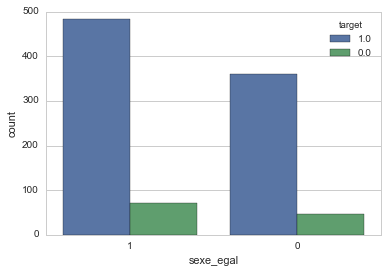

In [13]:
sns.countplot(x='sexe_egal', data=data, hue='target')

## Analyse même ville parrain / filleul (résidence)

In [15]:
# Parrain 
data["Code postal actuel"].head()

0    75010
1    75116
2    93100
3    92400
4    75017
Name: Code postal actuel, dtype: object

In [16]:
# filleul
data["Code postal"].head()

0    51100
1    95260
2    95260
3    69100
4    75010
Name: Code postal, dtype: object

In [22]:
data["code_postal_residence_egal"] = data.apply(lambda row: 1 if row["Code postal actuel"] == row["Code postal"] else 0, axis=1)

In [23]:
data["code_postal_residence_egal"].value_counts()

0    953
1      9
Name: code_postal_residence_egal, dtype: int64

## Analyse même ville parrain / filleul (école)

In [21]:
# filleul
data[u"Code postal de l'établissement actuel"].head()

0    51100
1    95000
2    78351
3    69001
4    75000
Name: Code postal de l'établissement actuel, dtype: object

In [25]:
data["code_postal_residence_egal"] = data.apply(lambda row: 1 if row["Code postal actuel"] == row[u"Code postal de l'établissement actuel"] else 0, axis=1)

In [26]:
data["code_postal_residence_egal"].value_counts()

0    950
1     12
Name: code_postal_residence_egal, dtype: int64

## Analyse Age parrain / filleul

In [79]:
# Parrain :
data["annee_naissance_p"] = pd.to_datetime(data["Date de naissance_p"], errors='coerce').dt.year

In [80]:
# Filleul :
data["annee_naissance_f"] = pd.to_datetime(data["Date de naissance_f"], errors='coerce').dt.year

In [81]:
data["annee_naissance_f"].head()

0    1996
1    1991
2    1993
3    1997
4    1994
Name: annee_naissance_f, dtype: int64

In [82]:
data['diff_annee_naissance'] = data["annee_naissance_f"] - data["annee_naissance_p"]

In [83]:
data['diff_annee_naissance'].describe()

count    779.000000
mean      14.178434
std       10.798231
min      -22.000000
25%        9.000000
50%       12.000000
75%       17.000000
max       92.000000
Name: diff_annee_naissance, dtype: float64

In [87]:
data[["Date de naissance_p", "annee_naissance_f"]][data['diff_annee_naissance'] == -22.0]

,Date de naissance_p,annee_naissance_f
472,2013-11-25 00:00:00,1991


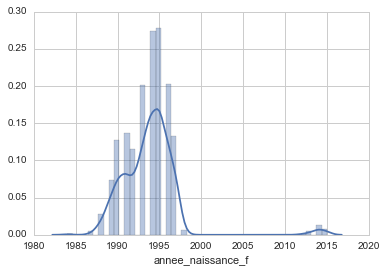

In [89]:
sns.distplot(data.annee_naissance_f)

## Age du Filleul

In [90]:
import datetime

In [168]:
pd.datetime.now().year

2016

In [169]:
today = datetime.date.today()
#data['age_f'] = ((pd.to_datetime(data["Date de naissance_f"], errors='coerce') - pd.datetime.now()) \
#                 / np.timedelta64(1, 'D')).astype(int)

data['age_f'] = pd.datetime.now().year - pd.to_datetime(data["Date de naissance_f"], errors='coerce').dt.year

In [170]:
data['age_f'].head()

0    20
1    25
2    23
3    19
4    22
Name: age_f, dtype: int64

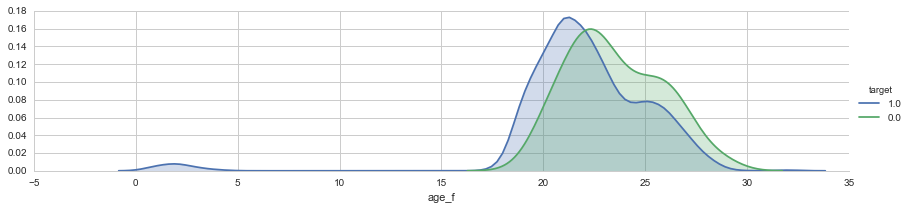

In [171]:
facet = sns.FacetGrid(data, hue="target",aspect=4)
facet.map(sns.kdeplot,'age_f',shade= True)
facet.add_legend()

## Age Parrain

In [172]:
data['age_p'] = pd.datetime.now().year - pd.to_datetime(data["Date de naissance_p"], errors='coerce').dt.year

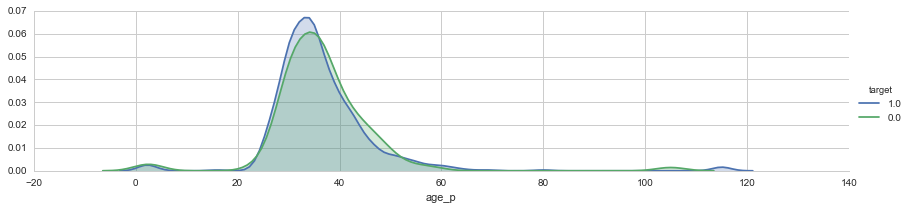

In [173]:
facet = sns.FacetGrid(data, hue="target",aspect=4)
facet.map(sns.kdeplot,'age_p',shade= True)
facet.add_legend()